In [41]:
%pip install kagglehub
%pip install librosa
%pip install tqdm
%pip install torch

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\Tawan\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\Tawan\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.




[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\Tawan\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\Tawan\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [42]:
import kagglehub
import numpy as np
import pandas as pd
from scipy.io.wavfile import read
import torch
import os
import re
import librosa
import librosa.display
import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [43]:
path = kagglehub.dataset_download("ejlok1/surrey-audiovisual-expressed-emotion-savee")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Tawan\.cache\kagglehub\datasets\ejlok1\surrey-audiovisual-expressed-emotion-savee\versions\1


In [44]:
abbreviates = ["a", "d", "f", "h", "sa", "su", "n"]
categories = {x: i for i, x  in enumerate(abbreviates)}

In [45]:
def extract_code(filename):
    match = re.search(r'^[A-Z]{2}_(\D+)\d{2}\.wav$', filename)
    return match.group(1) if match else None

def extract_spectrogram(file_path, sr=22050, n_fft=2048, hop_length=512, n_mels=128):
    y, sr = librosa.load(file_path, sr=sr)
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    return log_spectrogram

In [46]:
wavs_path = os.path.join(path, os.listdir(path)[0])
wavs = os.listdir(wavs_path)

x, y = [], []

for wav in tqdm.tqdm(wavs):
    file_path = os.path.join(wavs_path, wav)
    spectrogram = extract_spectrogram(file_path)
    code = extract_code(wav)
    x.append(spectrogram)
    y.append(categories[code])

max_length = max([spec.shape[1] for spec in x])

x = np.array([np.pad(spec, ((0, 0), (0, max_length - spec.shape[1])), mode='constant', constant_values=np.min(spec)) for spec in x])
y = np.array(y)

x.shape, y.shape

100%|██████████| 480/480 [00:03<00:00, 121.57it/s]


((480, 128, 308), (480,))

In [47]:
classes, counts = np.unique(y, return_counts=True)
classes, counts

(array([0, 1, 2, 3, 4, 5, 6]),
 array([ 60,  60,  60,  60,  60,  60, 120], dtype=int64))

Since class imbalance could cause us to misunderstand our accuracies, we should undersample or oversample our classes

In [48]:
min_class_size = min(counts)

x_list, y_list = list(x), list(y)
class_to_samples = {label: [] for label in np.unique(y)}
for spec, label in zip(x_list, y_list):
    class_to_samples[label].append(spec)

x_balanced, y_balanced = [], []
for label, samples in class_to_samples.items():
    undersampled_samples = resample(
        samples, n_samples=min_class_size, random_state=42, replace=False
    )
    x_balanced.extend(undersampled_samples)
    y_balanced.extend([label] * min_class_size)

x = np.array(x_balanced)
y = np.array(y_balanced)
np.unique(y, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]),
 array([60, 60, 60, 60, 60, 60, 60], dtype=int64))

We must convert waves into spectrograms to reduce dimensionality. If you want to see what this means try removing extract_spectrogram(). You will see that the maximum length will be 300k. This is extremely high and the model will likely not be able to train due to the load.

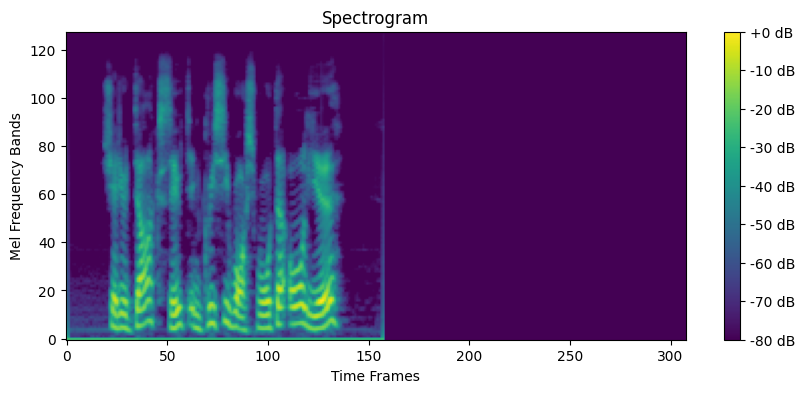

In [49]:
plt.figure(figsize=(10, 4))
plt.imshow(x[0], aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram")
plt.xlabel("Time Frames")
plt.ylabel("Mel Frequency Bands")
plt.show()

This is a spectrogram. It is a representation of frequencies of a signal over time. We can do extract alot of features based on this

In [50]:
def zcr(x):
    return np.squeeze(librosa.feature.zero_crossing_rate(x))

def rms(x):
    return np.squeeze(librosa.feature.rms(y = x))

def mfcc(x):
    return np.ravel(librosa.feature.mfcc(y=x).T)

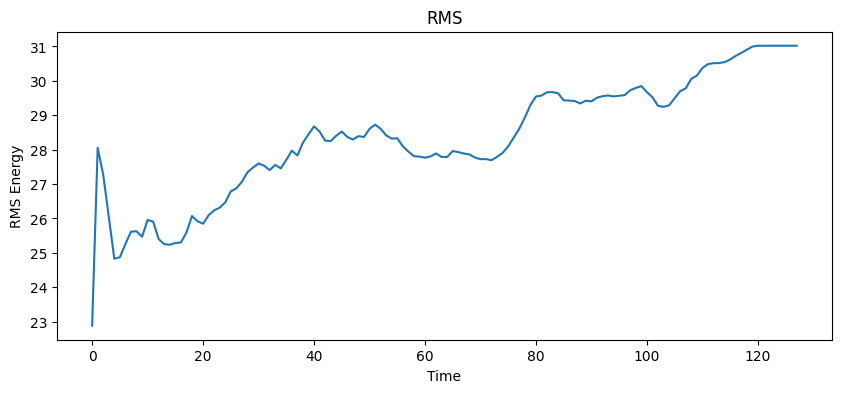

In [51]:
plt.figure(figsize=(10, 4))
plt.plot(rms(x[0]))
plt.title("RMS")
plt.xlabel("Time")
plt.ylabel("RMS Energy")
plt.show()

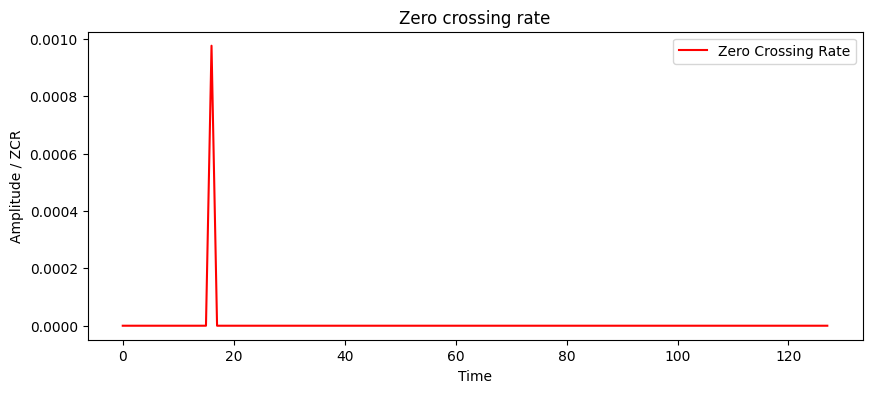

In [52]:
plt.figure(figsize=(10, 4))
plt.plot(zcr(x[0]), label='Zero Crossing Rate', color='r')
plt.title('Zero crossing rate')
plt.xlabel('Time')
plt.ylabel('Amplitude / ZCR')
plt.legend(loc='upper right')
plt.show()

In [53]:
def extract_features(x):
    result = np.array([])
    result = np.hstack((result, np.mean(x), np.std(x)))
    result = np.hstack((result, zcr(x)))
    result = np.hstack((result, rms(x)))
    return result

In [54]:
features = np.array([extract_features(spec) for spec in x])
x.shape, y.shape, features.shape

((420, 128, 308), (420,), (420, 258))

Before we add features to our training sample, lets try training only with spectrograms.

In [55]:
scaler = StandardScaler()
x_normalized = np.array([scaler.fit_transform(k) for k in x])
x_normalized.shape

(420, 128, 308)

In [56]:
x_tensor = torch.tensor(x_normalized, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype = torch.int64)

x_tensor.shape, y_tensor.shape

(torch.Size([420, 128, 308]), torch.Size([420]))

In [57]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_tensor, y_tensor, test_size=0.3, random_state=42)
y_train = y_train.squeeze()
y_test = y_test.squeeze()

In [58]:
import torch
import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTMClassifier, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True)
        self.drop1 = nn.Dropout(p=0.2)
        #We use bidirectional so the hidden-size is *2 so this needs to be hidden_size * 2
        #Bidirectional is like 2 models stuck together where each overlap and shifts left and right
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.drop1(x)
        x = x[:, -1, :]
        x = self.fc(x)
        return x

In [59]:
batch_size = 64
train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size)

Epoch 1/100, Train Loss: 1.9693, Test Loss: 1.9444, Test Accuracy: 18.25%
Epoch 2/100, Train Loss: 1.9644, Test Loss: 1.9437, Test Accuracy: 17.46%
Epoch 3/100, Train Loss: 1.9541, Test Loss: 1.9432, Test Accuracy: 17.46%
Epoch 4/100, Train Loss: 1.9562, Test Loss: 1.9428, Test Accuracy: 15.87%
Epoch 5/100, Train Loss: 1.9551, Test Loss: 1.9425, Test Accuracy: 15.87%
Epoch 6/100, Train Loss: 1.9531, Test Loss: 1.9418, Test Accuracy: 14.29%
Epoch 7/100, Train Loss: 1.9498, Test Loss: 1.9415, Test Accuracy: 14.29%
Epoch 8/100, Train Loss: 1.9452, Test Loss: 1.9415, Test Accuracy: 13.49%
Epoch 9/100, Train Loss: 1.9489, Test Loss: 1.9413, Test Accuracy: 14.29%
Epoch 10/100, Train Loss: 1.9416, Test Loss: 1.9409, Test Accuracy: 13.49%
Epoch 11/100, Train Loss: 1.9392, Test Loss: 1.9404, Test Accuracy: 15.08%
Epoch 12/100, Train Loss: 1.9414, Test Loss: 1.9401, Test Accuracy: 15.08%
Epoch 13/100, Train Loss: 1.9396, Test Loss: 1.9395, Test Accuracy: 15.08%
Epoch 14/100, Train Loss: 1.9291, 

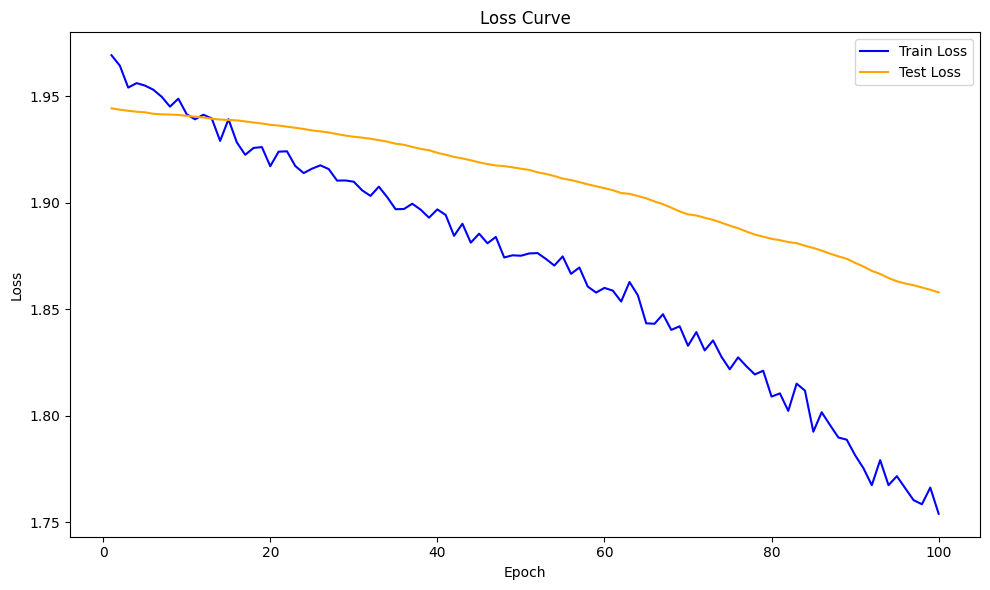

In [60]:
train_losses = []
test_losses = []

num_epochs = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMClassifier(308, 128, len(classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.00002)

best_accuracy = float('inf')
best_model_state = None

for epoch in range(num_epochs):
    
    model.train()
    running_train_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()  
        optimizer.step()
        running_train_loss += loss.item()
    
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    running_test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            loss = criterion(output, target)
            running_test_loss += loss.item()

            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    avg_test_loss = running_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

    if accuracy < best_accuracy:
        best_accuracy = accuracy
        best_model_state = model.state_dict()

model.load_state_dict(best_model_state)

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.tight_layout()
plt.show()

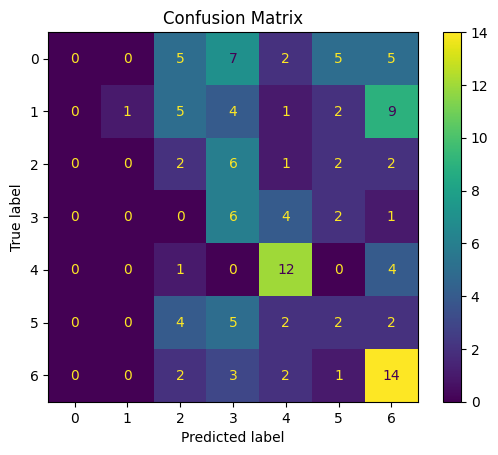

In [61]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_preds = []
all_targets = []

model.eval()
with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        _, predicted = torch.max(output, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

cm = confusion_matrix(all_targets, all_preds)
labels = list(range(len(classes)))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='viridis', values_format='d')
plt.title("Confusion Matrix")
plt.show()

You can see here that the two curves still are pointing down so we could train longer if needed.

In [62]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        #WE use bidirectional so the hidden-size is *2 so this needs to be hidden_size * 2
        self.attention = nn.Linear(hidden_size * 2, 1)
        
    def forward(self, x):
        weights = torch.softmax(self.attention(x), dim=1) 
        context = torch.sum(weights * x, dim=1)
        return context, weights

class LSTMAttentionClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, conv_kernel_size=3):
        super(LSTMAttentionClassifier, self).__init__()
        
        #This is our feature extraction layer here.
        self.conv = nn.Conv1d(in_channels=input_size, 
                              out_channels=hidden_size, 
                              kernel_size=conv_kernel_size, 
                              padding=conv_kernel_size // 2)
        
        self.lstm1 = nn.LSTM(hidden_size, hidden_size, batch_first=True, bidirectional=True)
        #Attention is basically what the area where the model can focus on.
        self.attention = Attention(hidden_size)
        
        self.drop1 = nn.Dropout(p=0.2)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.conv(x)
        x = x.transpose(1, 2)
        x, _ = self.lstm1(x)
        x, weights = self.attention(x)
        x = self.drop1(x)
        x = self.fc(x)
        return x, weights

Epoch 1/100, Train Loss: 1.9472, Test Loss: 1.9398, Test Accuracy: 19.05%
Epoch 2/100, Train Loss: 1.9471, Test Loss: 1.9397, Test Accuracy: 21.43%
Epoch 3/100, Train Loss: 1.9467, Test Loss: 1.9397, Test Accuracy: 19.84%
Epoch 4/100, Train Loss: 1.9465, Test Loss: 1.9398, Test Accuracy: 22.22%
Epoch 5/100, Train Loss: 1.9462, Test Loss: 1.9398, Test Accuracy: 17.46%
Epoch 6/100, Train Loss: 1.9458, Test Loss: 1.9399, Test Accuracy: 19.05%
Epoch 7/100, Train Loss: 1.9451, Test Loss: 1.9400, Test Accuracy: 17.46%
Epoch 8/100, Train Loss: 1.9447, Test Loss: 1.9401, Test Accuracy: 19.05%
Epoch 9/100, Train Loss: 1.9416, Test Loss: 1.9402, Test Accuracy: 17.46%
Epoch 10/100, Train Loss: 1.9413, Test Loss: 1.9403, Test Accuracy: 16.67%
Epoch 11/100, Train Loss: 1.9416, Test Loss: 1.9404, Test Accuracy: 16.67%
Epoch 12/100, Train Loss: 1.9391, Test Loss: 1.9405, Test Accuracy: 16.67%
Epoch 13/100, Train Loss: 1.9403, Test Loss: 1.9404, Test Accuracy: 16.67%
Epoch 14/100, Train Loss: 1.9383, 

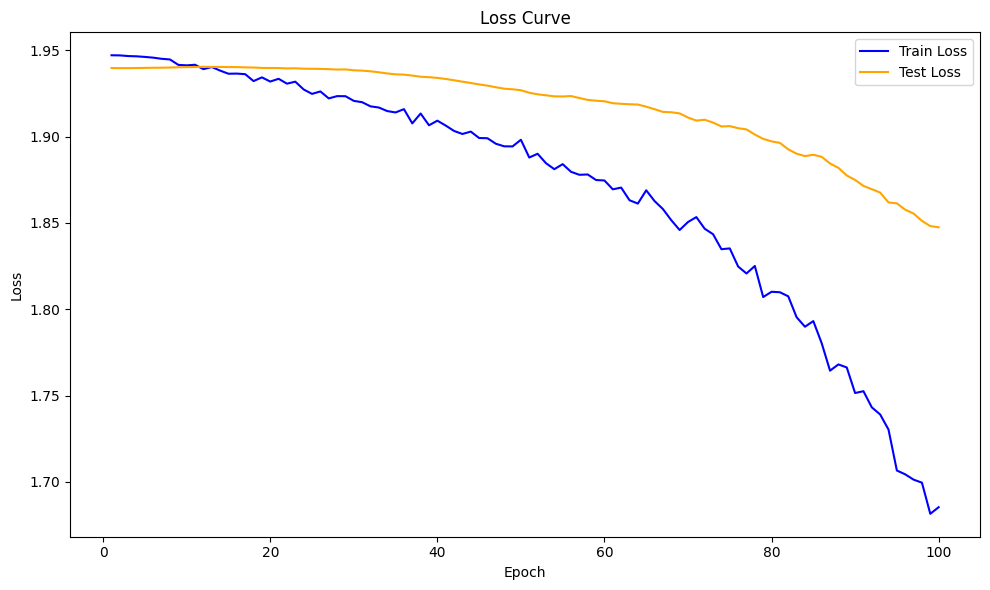

In [63]:
train_losses = []
test_losses = []

model = LSTMAttentionClassifier(308, 128, len(classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.00002)

best_accuracy = float('inf')
best_model_state = None

for epoch in range(num_epochs):
    
    model.train()
    running_train_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output, _ = model(data)
        loss = criterion(output, target)
        loss.backward()  
        optimizer.step()
        running_train_loss += loss.item()
    
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    running_test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            output, _ = model(data)
            loss = criterion(output, target)
            running_test_loss += loss.item()

            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    avg_test_loss = running_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

    if accuracy < best_accuracy:
        best_accuracy = accuracy
        best_model_state = model.state_dict()

model.load_state_dict(best_model_state)

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.tight_layout()
plt.show()

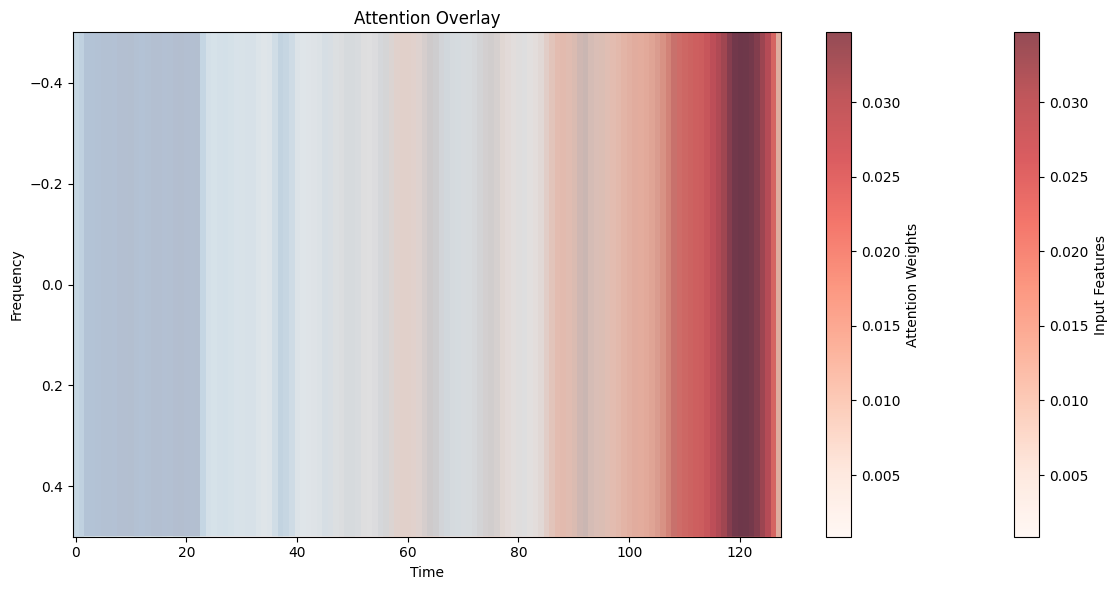

In [64]:
model.eval()

data, _ = next(iter(test_loader))
data = data.to(device)

with torch.no_grad():
    output, weights = model(data)

weights = weights[0].cpu().numpy()

input_data = data[0].cpu().numpy()

plt.figure(figsize=(12, 6))
plt.imshow(input_data, aspect='auto', cmap='Blues')
plt.imshow(weights[np.newaxis, :], aspect='auto', cmap='Reds', alpha=0.7)
plt.colorbar(label="Input Features")
plt.colorbar(label="Attention Weights")
plt.title("Attention Overlay")
plt.xlabel("Time")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

We can see here that the attention is focused at the end of the sequence. So this could mean that frequencies at the end could correlate well with the outcome

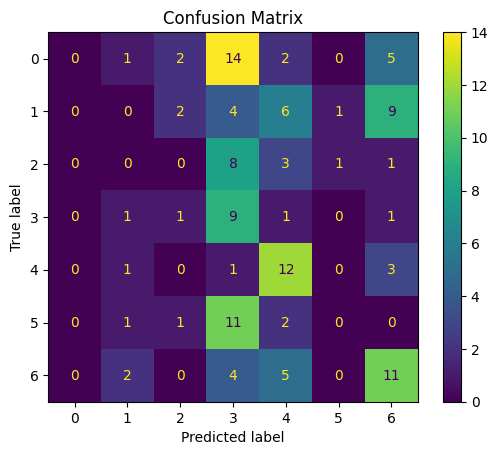

In [65]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_preds = []
all_targets = []

model.eval()
with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        output, _ = model(data)
        _, predicted = torch.max(output, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

cm = confusion_matrix(all_targets, all_preds)
labels = list(range(len(classes)))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='viridis', values_format='d')
plt.title("Confusion Matrix")
plt.show()

Now lets try adding the previosly extracted features

In [66]:
x.shape, features.shape

((420, 128, 308), (420, 258))

In [67]:
features = np.array([extract_features(spec) for spec in x])
features = features[:, np.newaxis, :] 
features = np.repeat(features, x.shape[1], axis=1)
#We add a new axis to turn features into (420, 1, 2818) before repeating 12 times to be (420, 12, 2818)
x.shape, features.shape

((420, 128, 308), (420, 128, 258))

In [68]:
x_with_features = np.concatenate([x, features], axis=2)
x_with_features.shape

(420, 128, 566)

In [69]:
x_tensor = torch.tensor(x_with_features, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype = torch.int64)

In [70]:
x_train, x_test, y_train, y_test = train_test_split(x_tensor, y_tensor, test_size=0.3, random_state=42)
y_train = y_train.squeeze()
y_test = y_test.squeeze()

In [71]:
batch_size = 64
train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size)

Epoch 1/100, Train Loss: 1.9788, Test Loss: 1.9327, Test Accuracy: 19.05%
Epoch 2/100, Train Loss: 1.9535, Test Loss: 1.9318, Test Accuracy: 18.25%
Epoch 3/100, Train Loss: 1.9595, Test Loss: 1.9305, Test Accuracy: 17.46%
Epoch 4/100, Train Loss: 1.9549, Test Loss: 1.9284, Test Accuracy: 19.84%
Epoch 5/100, Train Loss: 1.9520, Test Loss: 1.9307, Test Accuracy: 21.43%
Epoch 6/100, Train Loss: 1.9613, Test Loss: 1.9311, Test Accuracy: 21.43%
Epoch 7/100, Train Loss: 1.9510, Test Loss: 1.9330, Test Accuracy: 20.63%
Epoch 8/100, Train Loss: 1.9534, Test Loss: 1.9334, Test Accuracy: 21.43%
Epoch 9/100, Train Loss: 1.9527, Test Loss: 1.9323, Test Accuracy: 21.43%
Epoch 10/100, Train Loss: 1.9537, Test Loss: 1.9295, Test Accuracy: 21.43%
Epoch 11/100, Train Loss: 1.9550, Test Loss: 1.9319, Test Accuracy: 26.19%
Epoch 12/100, Train Loss: 1.9518, Test Loss: 1.9329, Test Accuracy: 25.40%
Epoch 13/100, Train Loss: 1.9511, Test Loss: 1.9313, Test Accuracy: 24.60%
Epoch 14/100, Train Loss: 1.9488, 

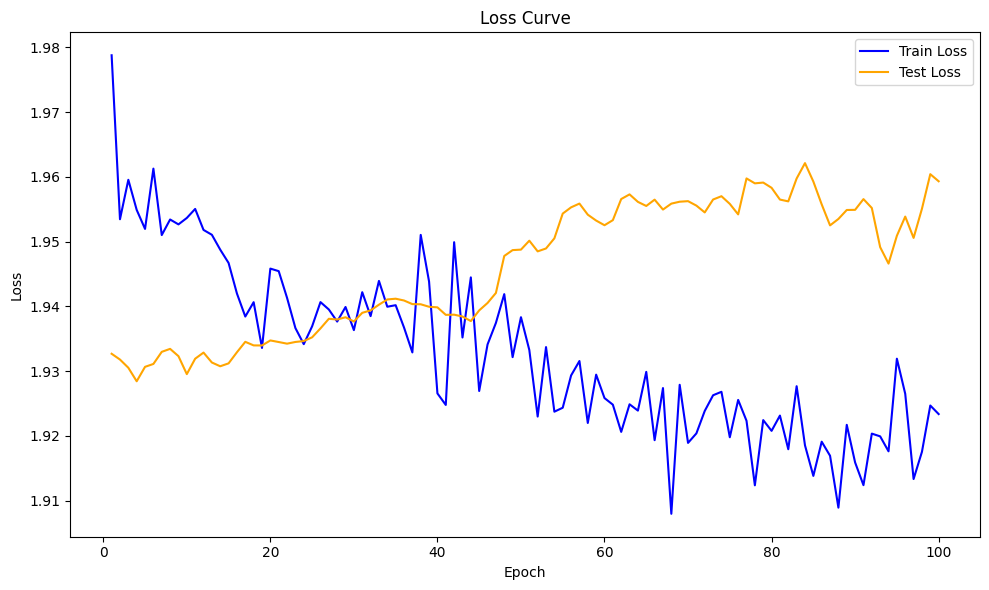

In [72]:
train_losses = []
test_losses = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMClassifier(x_with_features.shape[-1], 128, len(classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.00002)

best_accuracy = float('inf')
best_model_state = None

for epoch in range(num_epochs):
    
    model.train()
    running_train_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()  
        optimizer.step()
        running_train_loss += loss.item()
    
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    running_test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            loss = criterion(output, target)
            running_test_loss += loss.item()

            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    avg_test_loss = running_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

    if accuracy < best_accuracy:
        best_accuracy = accuracy
        best_model_state = model.state_dict()

model.load_state_dict(best_model_state)

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.tight_layout()
plt.show()

The result is self explanatory. Perhaps more features does not mean better performance with deep learning models. Though we can reduce the dimensionality by using PCA but it is not within the scope. Since the simple model does not work then the complex does not need to be checked

Now lets try traditional algorithms

In [73]:
import time

Test Accuracy: 41.27%
Time taken 2.509446382522583


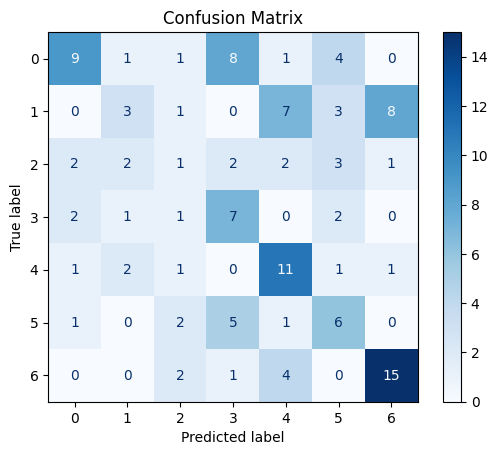

In [74]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

start_time = time.time()

X = x_with_features.reshape(x_with_features.shape[0], -1) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

accuracy = model.score(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Time taken {time.time() - start_time}")

y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

Test Accuracy: 38.10%
Time taken 1.6641507148742676


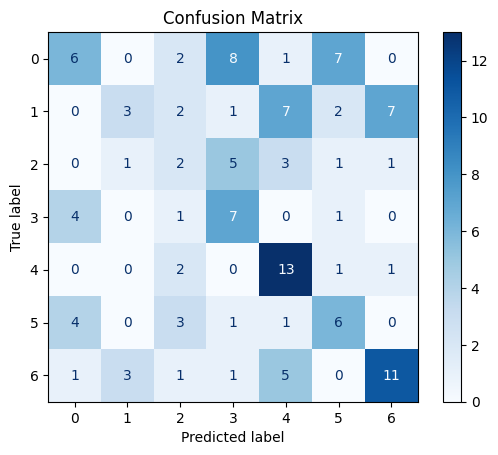

In [75]:
start_time = time.time()

X = x.reshape(x.shape[0], -1) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

accuracy = model.score(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Time taken {time.time() - start_time}")

y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

RFC actually works much better than both DL models even including the complex attention model. We can also conclude that adding features does indeed increase the accuracy with the cost of training time of 2x

If RFC works then how about gradient boosting algorithms? 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

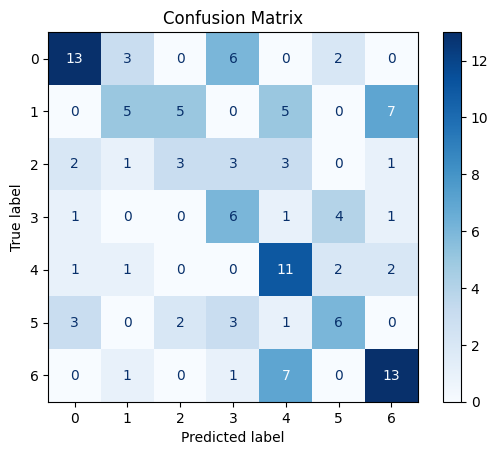

In [76]:
import lightgbm as lgb

start_time = time.time()

X = x_with_features.reshape(x_with_features.shape[0], -1) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = lgb.LGBMClassifier(random_state=42, verbosity = 0)
model.fit(X_train, y_train)

accuracy = model.score(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Time taken {time.time() - start_time}")

y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

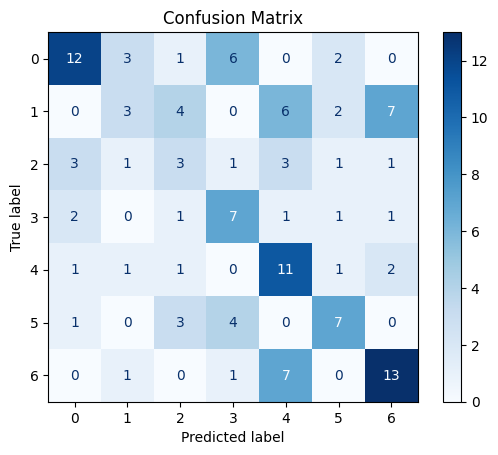

In [77]:
start_time = time.time()

X = x.reshape(x.shape[0], -1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = lgb.LGBMClassifier(random_state=42, verbosity = 0)

model.fit(X_train, y_train)

accuracy = model.score(X_test, y_test)

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Time taken: {time.time() - start_time} seconds")

y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

Unsurprisingly, the LGM works even better than RFC. However, the training time is 50x that of RFC.

We can conclude that traditional ML works the best with LGM Classifier using fequency derived features having the best accuracy at 45.24% accuracy.